### 01 London Propery Listings.ipynb

### Steps:
- Step 0: Imports and Locations

In [1]:
#========================================================================
# Step 0: Imports

# Imports
import pandas as pd
import numpy as np
import copy
pd.set_option('display.max_columns', 10000)
pd.set_option('display.max_rows', 10000)

# Seaborn
import seaborn as sns
import matplotlib.pyplot as plt

# XGBoost
from xgboost import XGBClassifier

# Model Performance
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
#========================================================================

In [2]:
#========================================================================
# Step 1: Load Data
df=pd.read_csv('London Property Listings Dataset.csv')
df.columns = df.columns.str.replace(' ', '_')

print('--------------------')
print('## Information ##')
df.info()
print('--------------------')
print('')

print('--------------------')
print('## First 5 rows ##')
print(df.head(5))
print('--------------------')
#========================================================================

--------------------
## Information ##
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29537 entries, 0 to 29536
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Price           29537 non-null  float64
 1   Property_Type   29537 non-null  object 
 2   Bedrooms        29537 non-null  float64
 3   Bathrooms       29537 non-null  float64
 4   Size            29537 non-null  float64
 5   Postcode        29537 non-null  object 
 6   Area            29537 non-null  object 
 7   Price_Category  29537 non-null  object 
 8   Area_Avg_Price  29537 non-null  float64
dtypes: float64(5), object(4)
memory usage: 2.0+ MB
--------------------

--------------------
## First 5 rows ##
      Price Property_Type  Bedrooms  Bathrooms   Size Postcode           Area  \
0  330000.0     Apartment       1.0        1.0  518.0      E14        Eastern   
1  340000.0          Flat       1.0        1.0    1.0      E14        Eastern   
2

In [ ]:
#========================================================================
# Step 2: Delete Outliers and Unnecessary Features

# Copy
df2=copy.deepcopy(df)

# Area_Avg_Price is simply the average of the price in the area
print('--------------------')
print('## Average Price for Each Area ##')
print(df[['Price','Area', 'Area_Avg_Price']].groupby(['Area', 'Area_Avg_Price']).mean())
print('--------------------')
print('')
df2=df2.drop(['Area_Avg_Price'], axis=1)

# Price_Category is simply banding the price into 4 categories
print('--------------------')
print('## Min and Max Price for each Price Category ##')
df[['Price','Price_Category']]\
    .groupby(['Price_Category'])\
    .agg(['min', 'max', 'count'])
print('--------------------')
print('')
df2=df2.drop(['Price_Category'], axis=1)

# Some areas have only a few examples, create a new feature to group these areas
area_summary=df2['Area'].value_counts().reset_index()
area_summary['AreaGroup']=np.where(area_summary['count']<100, 'Other',area_summary['Area'])
area_summary
df2=pd.merge(df2, area_summary[['Area', 'AreaGroup']], left_on='Area', right_on='Area', how='left')


df2[['AreaGroup','Area']].groupby(['AreaGroup','Area']).size().reset_index()

# 1 bedroom appartment, 144 bathrooms
print('--------------------')
print('## Outlier Bathrooms ##')
print(df2[df2['Bathrooms']>=20])
print('--------------------')
print('')
df2=df2[df2['Bathrooms']<20]

# 1, 3 and 5 bedroom appartments, sizes over 50,000 sq feet
print('--------------------')
print('## Outlier Size ##')
print(df2[df2['Size']>=50E3])
print('--------------------')
print('')
df2=df2[df2['Size']<50E3]

# Information
print('--------------------')
print('## Information ##')
df2.info()
print('--------------------')
print('')
#========================================================================

--------------------
## Average Price for Each Area ##
                                              Price
Area                   Area_Avg_Price              
Bromley                4.187500e+05    4.187500e+05
Croydon                4.352941e+05    4.352941e+05
Eastern                1.001684e+06    8.419240e+05
Eastern Central        1.410220e+06    1.235202e+06
Enfield                5.015973e+05    5.015973e+05
Harrow                 5.106283e+05    5.106283e+05
Ilford                 5.856667e+05    5.856667e+05
Kingston               5.700000e+05    5.700000e+05
Kingston upon Thames   8.009967e+05    8.009967e+05
North Western          1.237283e+06    1.005454e+06
Northern               8.312952e+05    7.686065e+05
South Eastern          6.921048e+05    6.653810e+05
South Western          1.516724e+06    1.216610e+06
Sutton                 6.616667e+05    6.616667e+05
Twickenham             8.512587e+05    8.512587e+05
Western Central        1.625819e+06    1.423378e+06
Western a

,AreaGroup,Area,0
0,Eastern,Eastern,13073
1,Eastern Central,Eastern Central,432
2,Enfield,Enfield,100
3,North Western,North Western,2376
4,Northern,Northern,1685
5,Other,Bromley,4
6,Other,Croydon,17
7,Other,Harrow,23
8,Other,Ilford,3
9,Other,Kingston,1


In [8]:
df[['Area','Postcode']]\
    .groupby(['Area','Postcode'])\
    .size().reset_index(name='Count')\
    .sort_values(by='Count', ascending=False)

,Area,Postcode,Count
11,Eastern,E14,10899
134,South Western,SW11,729
207,Western and Paddington,W2,617
157,South Western,SW6,518
102,South Eastern,SE1,493
13,Eastern,E16,368
159,South Western,SW8,350
75,North Western,NW8,347
76,North Western,NW9,320
6,Eastern,E1,305


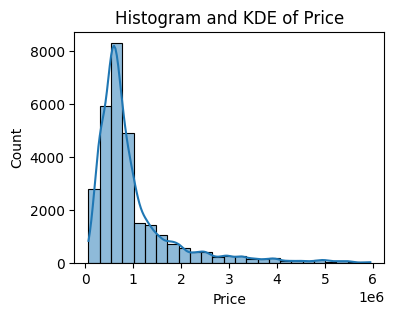

In [95]:
#========================================================================
# Step 2: Response
plt.figure(figsize=(4,3))
sns.histplot(df2, x='Price', bins=25, kde=True)
plt.title('Histogram and KDE of Price', loc='center')
plt.show()
#========================================================================

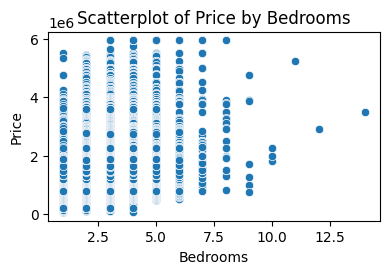

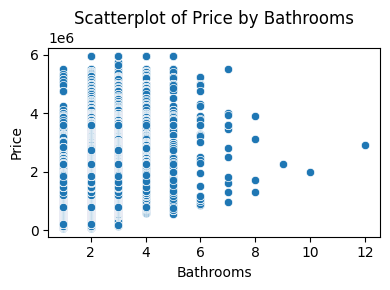

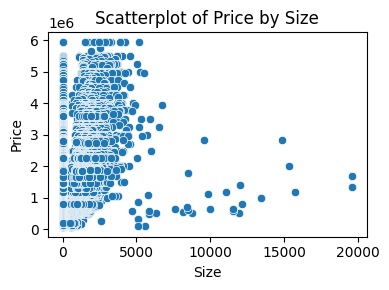

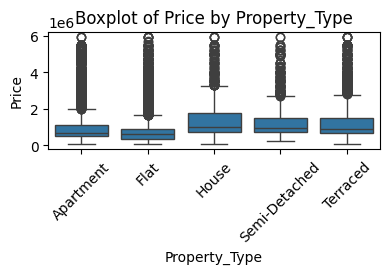

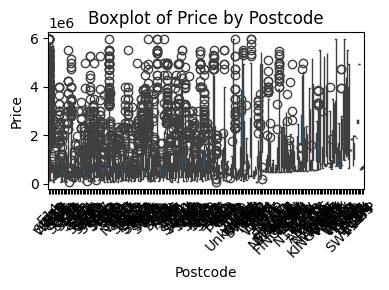

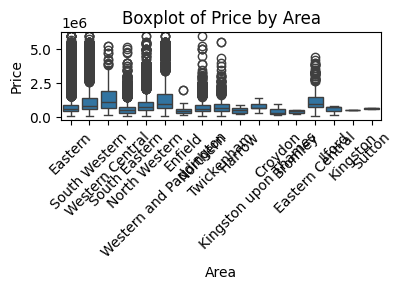

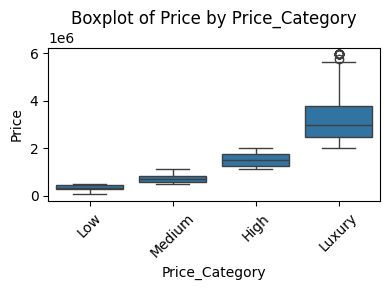

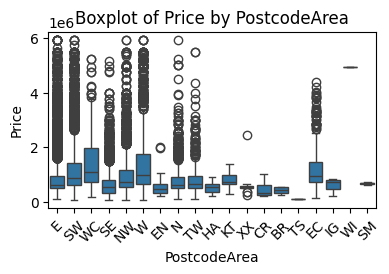

In [106]:
#========================================================================
# Step 3: Feature Analysis

# Continuous Features
numeric_cols = df2.select_dtypes(include=[np.number]).columns.drop('Price')
for this_var in numeric_cols:
    plt.figure(figsize=(4, 3))
    sns.scatterplot(data=df2, x=this_var, y='Price')
    plt.title(f'Scatterplot of Price by {this_var}', fontsize=12, loc='center')
    plt.tight_layout()
    plt.show()

# Categorical Features
character_cols = df2.select_dtypes(exclude=[np.number]).columns
for this_var in character_cols:
    plt.figure(figsize=(4, 3))
    sns.boxplot(data=df2, x=this_var, y='Price')
    plt.title(f'Boxplot of Price by {this_var}', fontsize=12, loc='center')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
#========================================================================